In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.model.prophet import ProphetPredictor
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

Importing plotly failed. Interactive plots will not work.


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)
'''
one_ts_train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df[train_set_df.location == "LK Bad Dürkheim"],
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)
'''
test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)
'''
one_ts_test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df[test_set_df.location == "LK Bad Dürkheim"],
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)
'''
# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=config.prediction_length, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

# SimpleFeedForward

In [3]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions


estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=config.prediction_length,
    context_length=config.context_length,
    distr_output=config.distr_output,
    trainer=Trainer(
        ctx="cpu",
        epochs=5,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)
predictor = estimator.train(train_set)


forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_set, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
forecasts = list(forecast_it)
tss = list(ts_it)

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 120.59it/s, epoch=5/5, avg_epoch_loss=1.05]


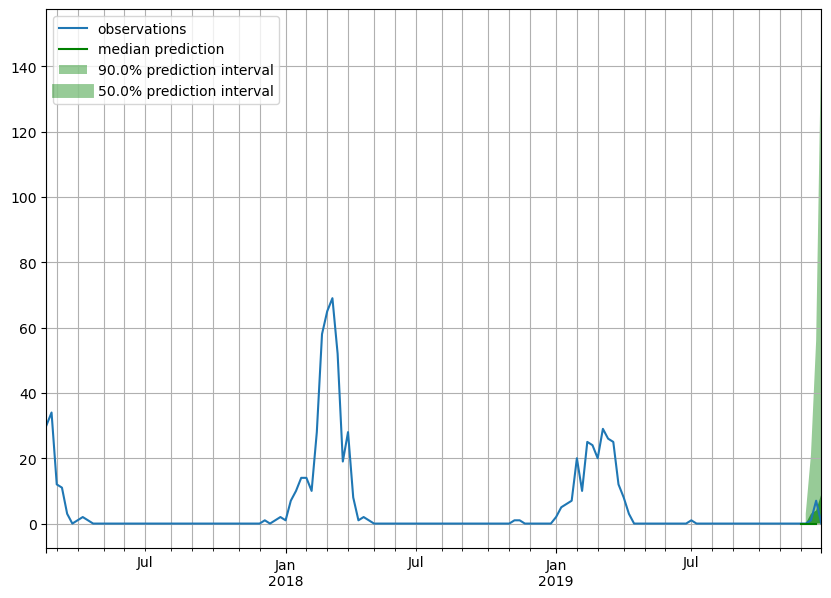

In [4]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(tss[0], forecasts[0])

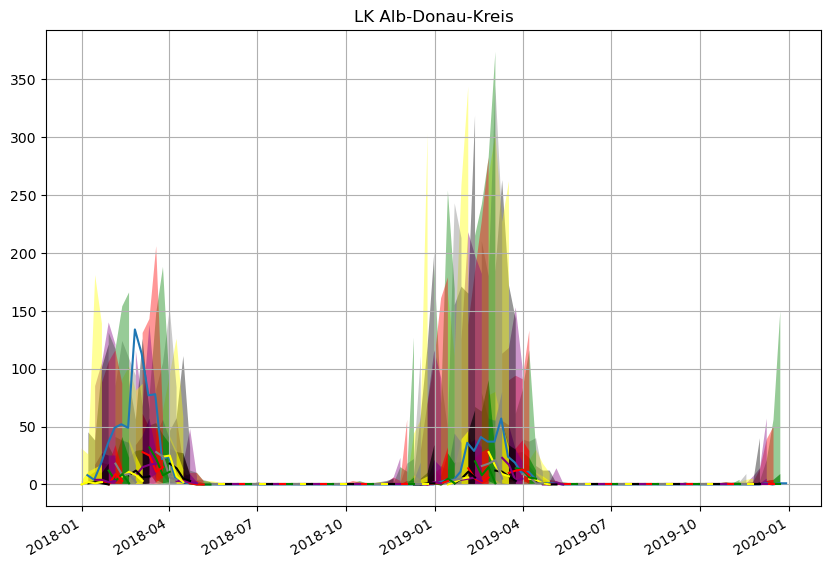

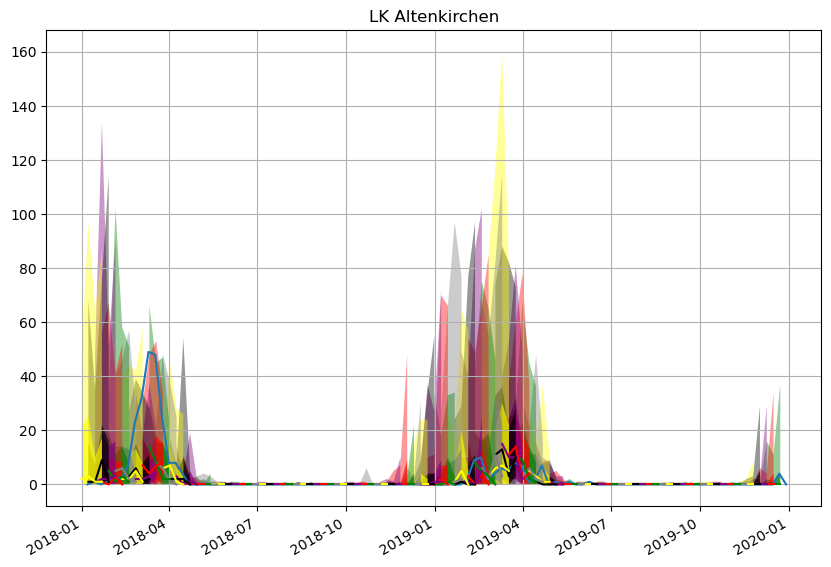

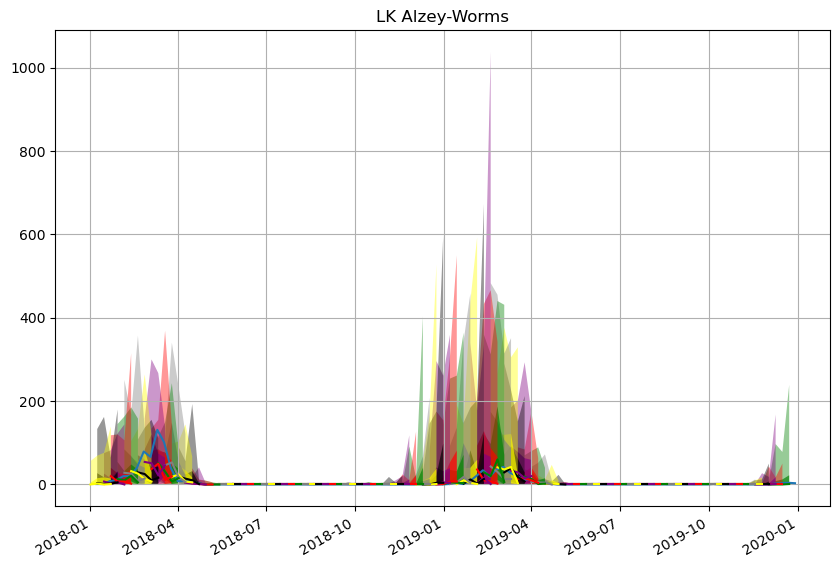

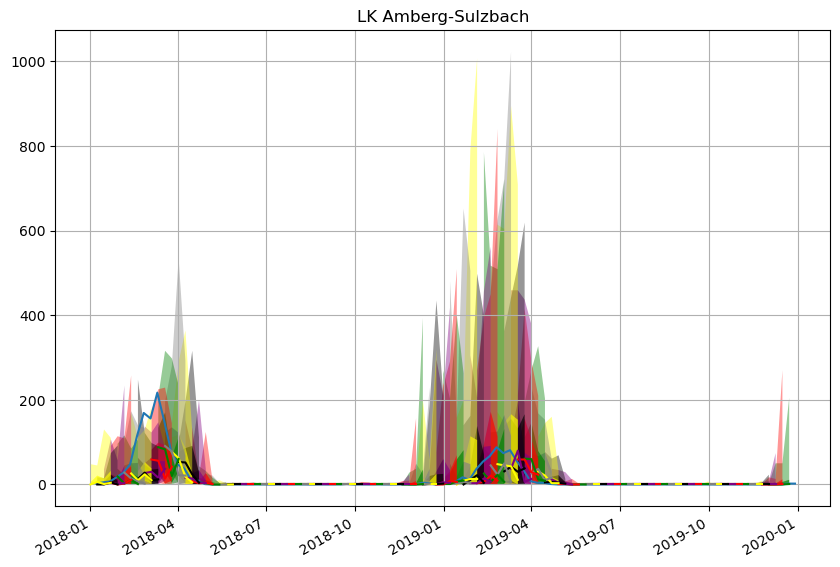

In [6]:
windows_per_location = int(len(test_set) / len(locations))
for location in locations[:4]:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                            (corrected_df.index <= config.test_end_time) &
                            (corrected_df.index >= config.train_end_time)].index),
             corrected_df.loc[(corrected_df['location'] == location) &
                           (corrected_df.index <= config.test_end_time) &
                           (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #define the colors to use for each different window
    color = ["g", "r", "purple", "black", "yellow", "grey"] * windows_per_location
    # Iterate through the correct index by changing the range with [windows_per_location]
    for k in range(0 + windows_per_location*locations.index(location),
                   windows_per_location + windows_per_location*locations.index(location)):
        forecast_entry = forecasts[k]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[k % windows_per_location])
    plt.grid(which="both")
    plt.show()

In [7]:
two_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)
one_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)
three_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)
four_week_ahead_forecasts, split_tss  = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)

In [13]:
print(one_week_ahead_forecasts[0])

gluonts.model.forecast.SampleForecast(info=None, item_id="LK Ahrweiler", samples=numpy.array([[0.0, 0.0, 26.0, 97.0, 6.0, 11.0, 77.0, 64.0, 19.0, 15.0, 19.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 0.0, 2.0, 43.0, 0.0, 10.0, 28.0, 354.0, 29.0, 0.0, 45.0, 0.0, 2.0, 7.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4.0, 0.0, 18.0, 7.0, 21.0, 16.0, 6.0, 15.0, 31.0, 46.0, 0.0, 1.0, 13.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 1.0, 3.0, 0.0, 178.0, 69.0, 43.0, 77.0, 115.0, 92.0, 0.0, 1.0, 69.0, 32.0, 13.0, 0.0, 1.0, 1.0, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

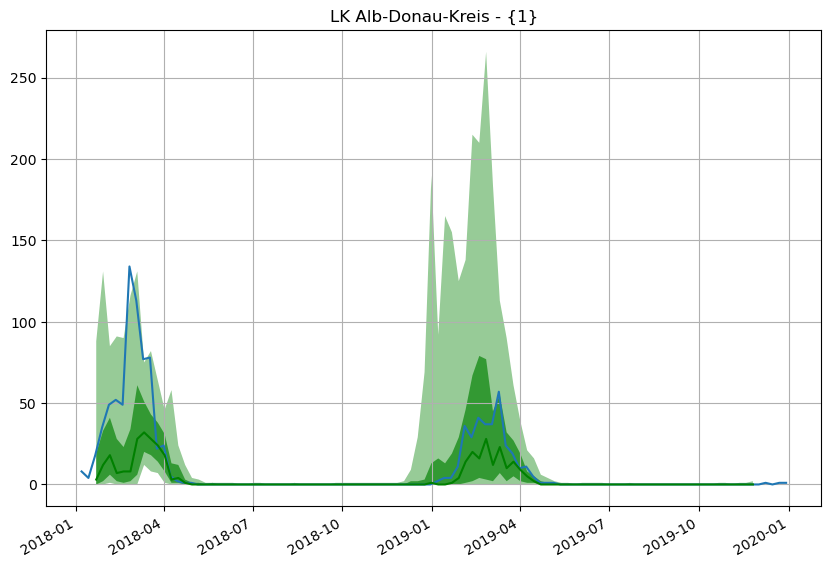

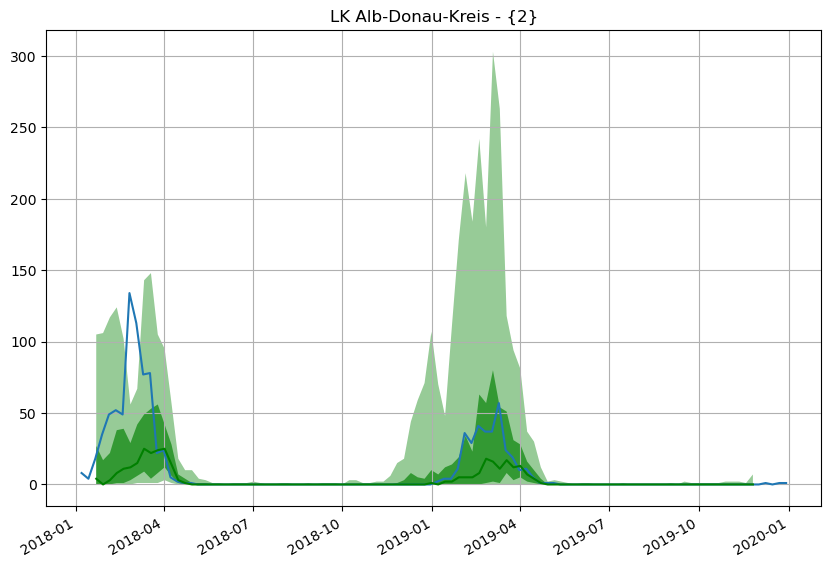

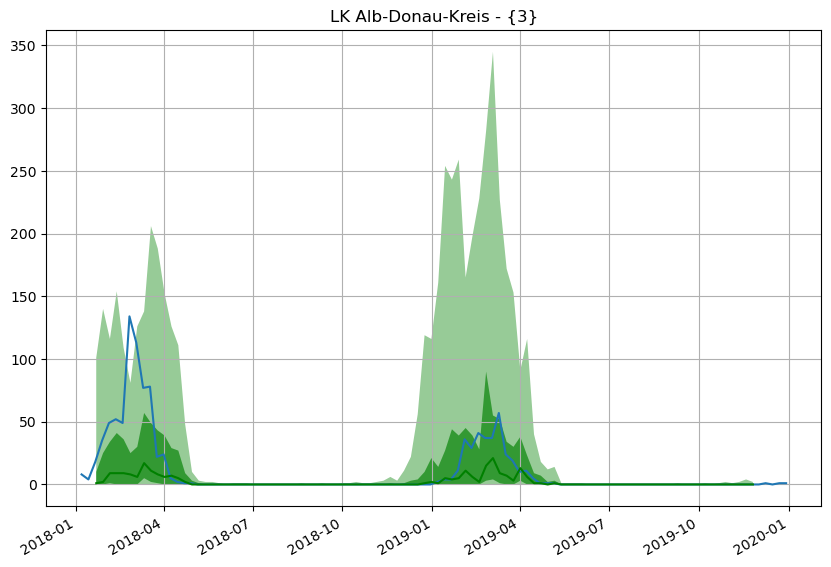

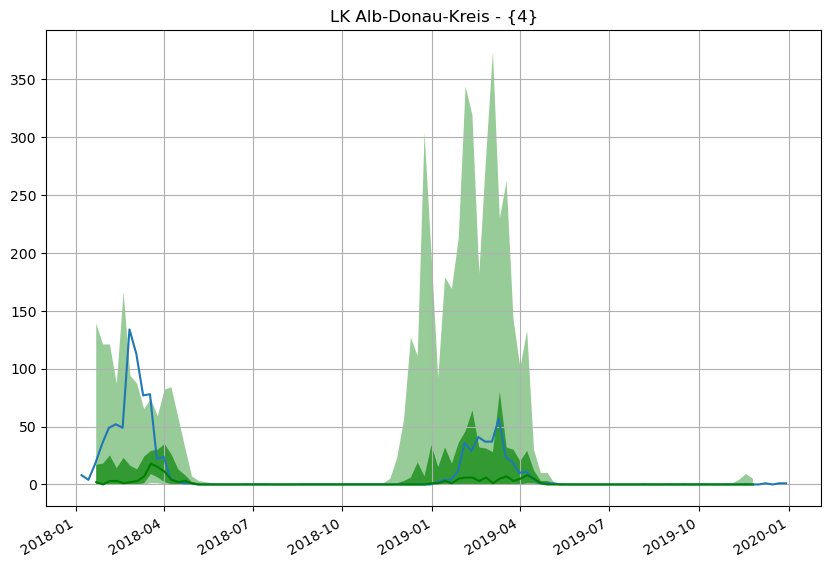

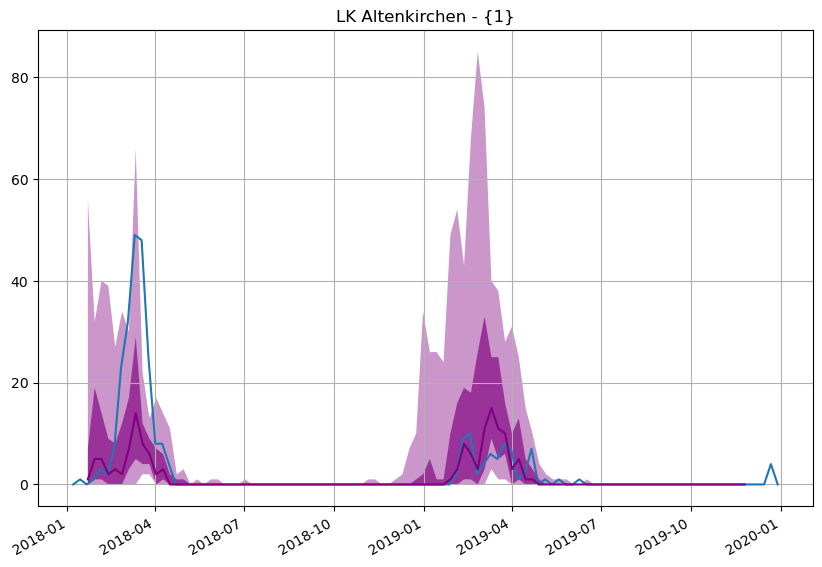

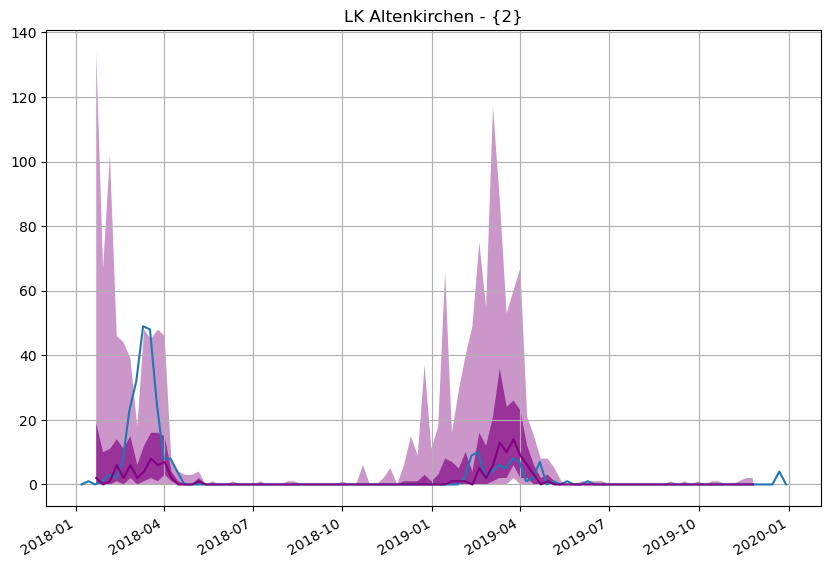

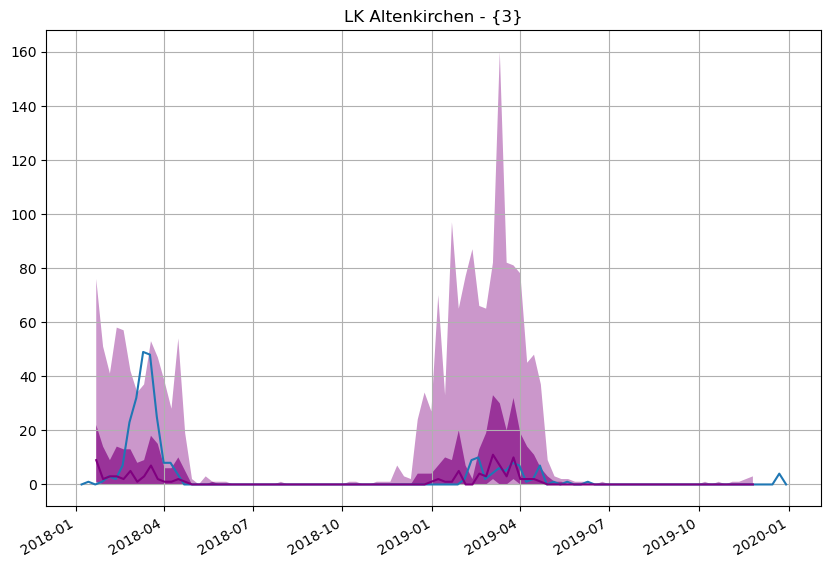

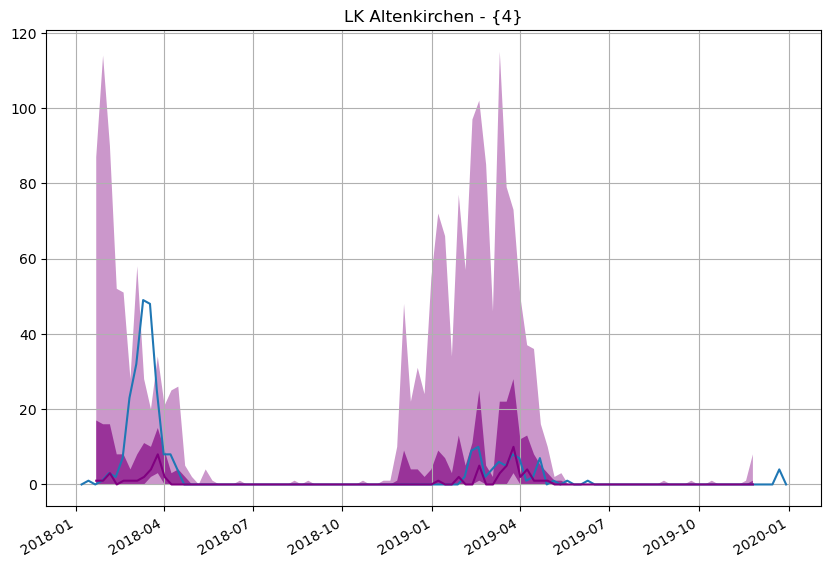

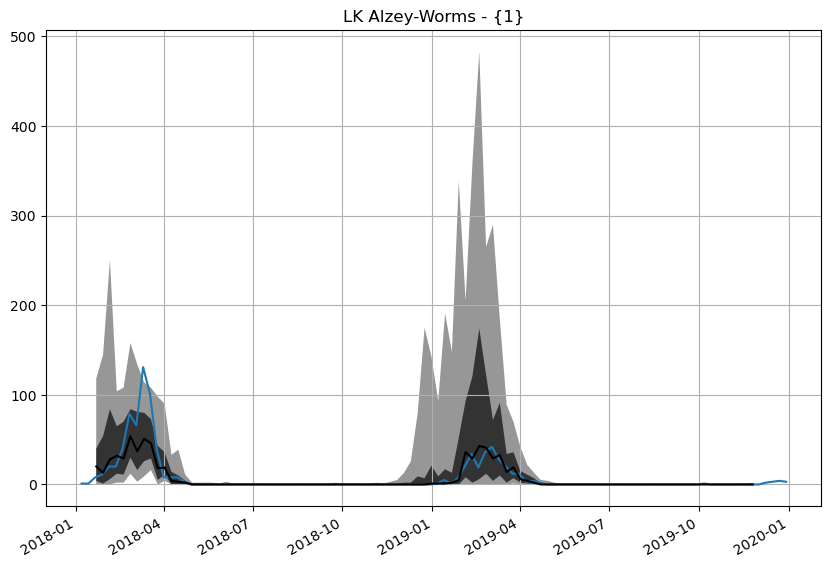

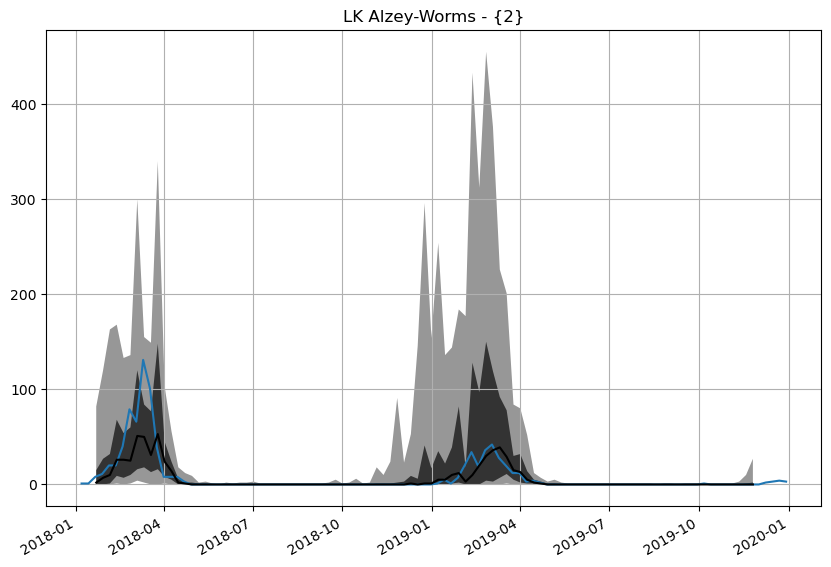

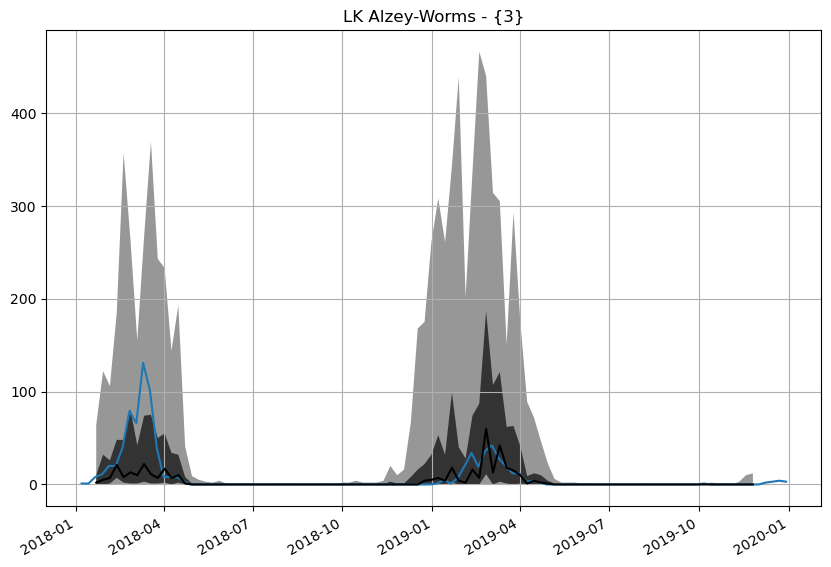

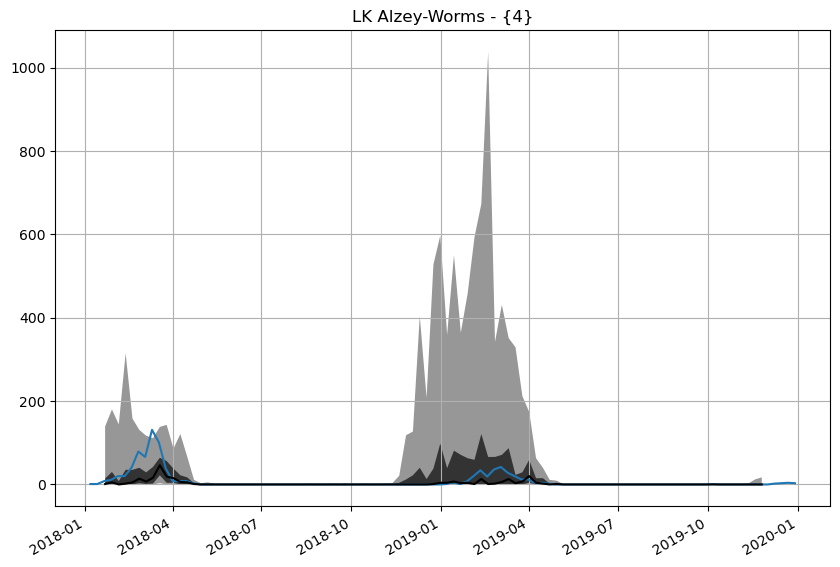

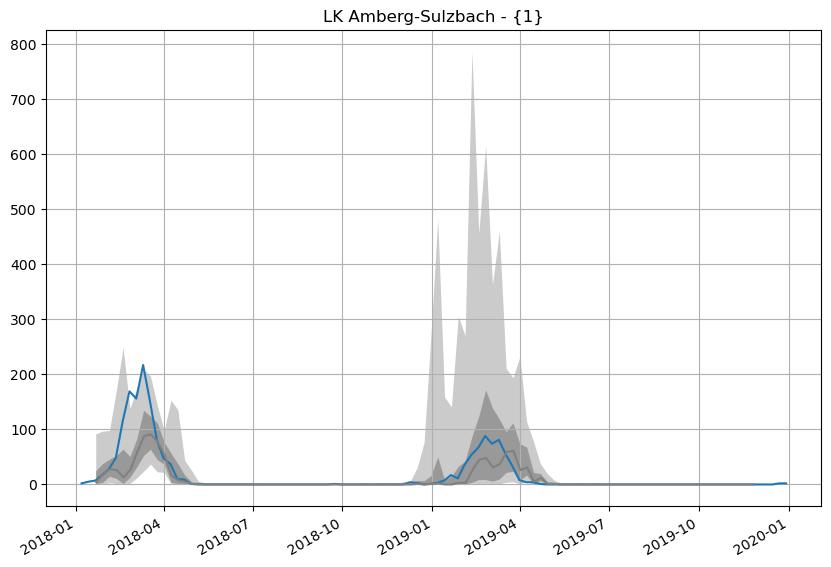

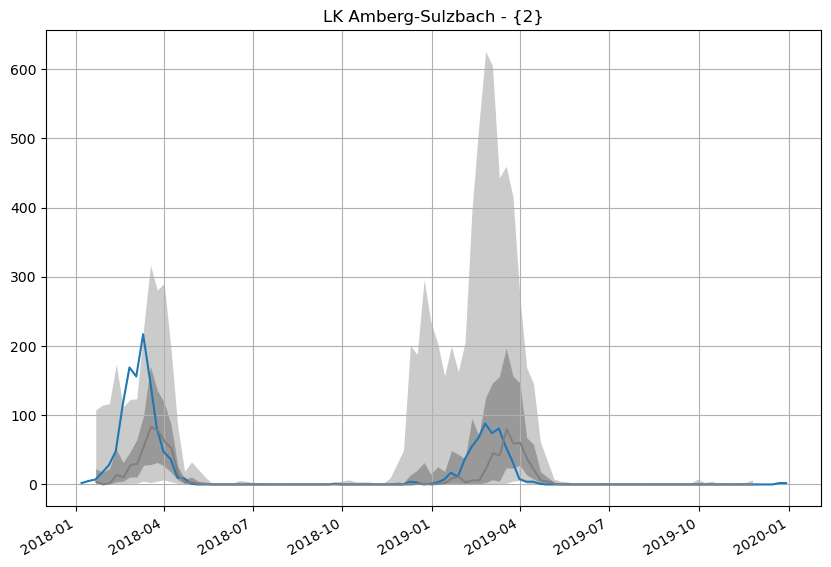

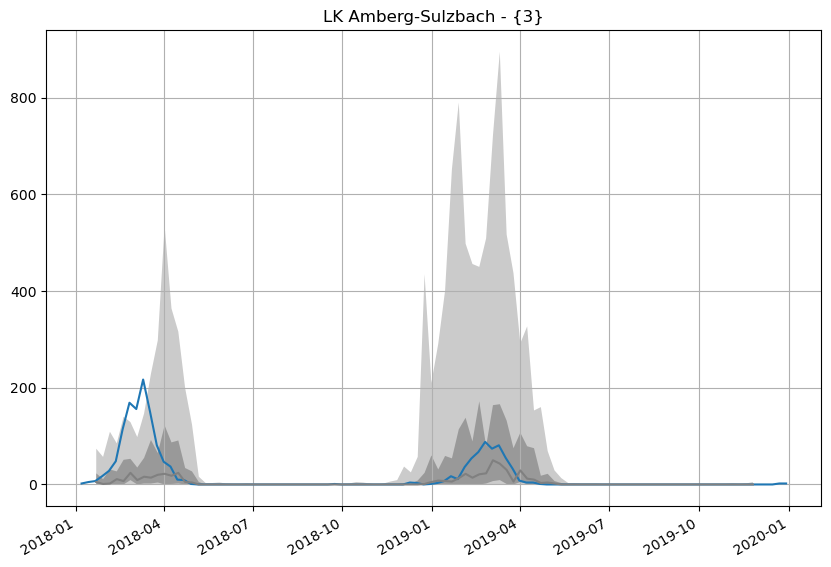

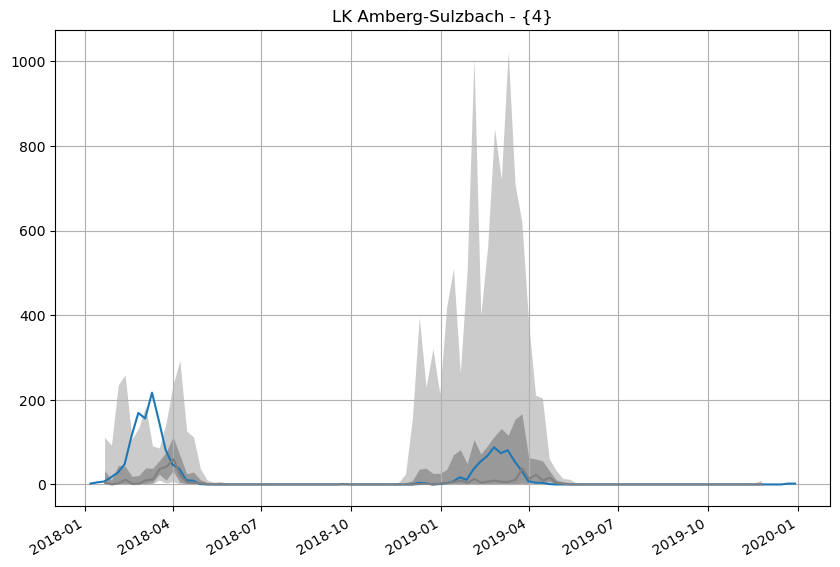

In [18]:
forecast_dict ={1 : one_week_ahead_forecasts,
                2 : two_week_ahead_forecasts,
                3 : three_week_ahead_forecasts,
                4 : four_week_ahead_forecasts}
for location in locations[:4]:
    for forecast in forecast_dict.values():
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        plt.title(f'{location} - {d}')
        # first plot the time series as a whole (x-axis: Date, y-axis: influenza-values)
        plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                                (corrected_df.index <= config.test_end_time) &
                                (corrected_df.index >= config.train_end_time)].index),
                 corrected_df.loc[(corrected_df['location'] == location) &
                               (corrected_df.index <= config.test_end_time) &
                               (corrected_df.index >= config.train_end_time), 'value'])
        #define the colors to use for each different window
        color = ["g", "purple", "black", "grey","yellow"]*windows_per_location
        forecast_entry = forecast[locations.index(location)]
        prediction_intervals = (50.0, 90.0)
        forecast_entry.plot(prediction_intervals=prediction_intervals, color=color[int(locations.index(location)) % windows_per_location])
        plt.grid(which="both")
        plt.show()

# Prophet

11:52:49 - cmdstanpy - INFO - Chain [1] start processing
11:52:49 - cmdstanpy - INFO - Chain [1] done processing


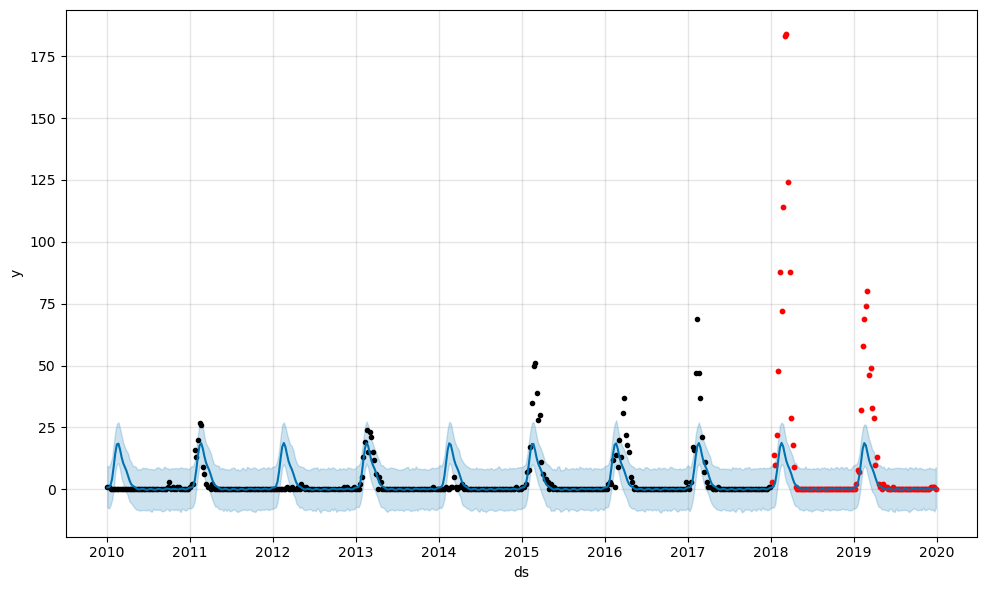

In [34]:
from prophet import Prophet
predictor = Prophet(growth= "flat")
prophet_df = corrected_df[corrected_df.location == "LK Bad Dürkheim"].reset_index(drop=False).rename(columns={"value":"y", "index":"ds"})[["ds", "y"]]
#prophet_df['y'] = np.log(prophet_df['y'] + 1)
train_prophet_df = prophet_df.loc[(prophet_df.ds >= config.train_start_time) &
                         (prophet_df.ds <= config.train_end_time),:]
test_prophet_df = prophet_df.loc[(prophet_df.ds >= config.train_end_time) &
                         (prophet_df.ds <= config.test_end_time),:]
predictor.fit(train_prophet_df)
future = predictor.make_future_dataframe(periods=104, freq=config.freq)
fcst = predictor.predict(future)
#for col in fcst.columns:
 #   if 'yhat' in col:
  #      fcst[col] = np.exp(fcst[col])-1
#test_prophet_df['y'] = np.exp(test_prophet_df['y'])-1
fig = predictor.plot(fcst)
plt.scatter((test_prophet_df['ds']),test_prophet_df['y'], c="red", s=10)

In [3]:
predictor = ProphetPredictor(prediction_length=104)
test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df[test_set_df.location == "LK Bad Dürkheim"],
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

forecasts = list(predictor.predict(train_set))

10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:53 - cmdstanpy - INFO - Chain [1] done processing
10:44:53 - cmdstanpy - INFO - Chain [1] start processing
10:44:54 - cmdstanpy - INFO - Chain [1]

2018-01-07 00:00:00


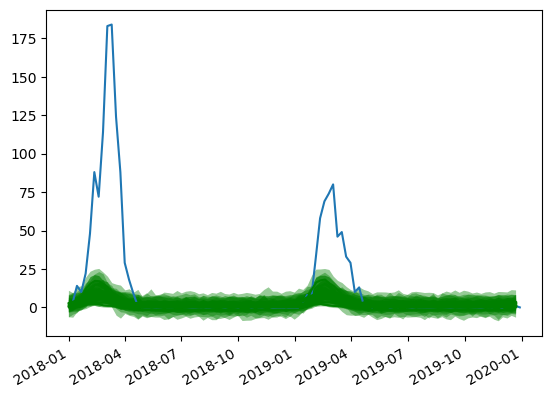

In [5]:
print(start_time)
prediction_intervals = (50.0, 90.0)
for location in ['LK Bad Dürkheim']:
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                        (corrected_df.index <= config.test_end_time) &
                        (corrected_df.index >= config.train_end_time)].index),
         corrected_df.loc[(corrected_df['location'] == location) &
                       (corrected_df.index <= config.test_end_time) &
                       (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
    #print(forecasts[-1:])
    for forecast in forecasts[-10:]:
        forecast.plot(prediction_intervals=prediction_intervals, color="g")
    plt.show()

# Naive

In [1]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
estimator = SeasonalNaivePredictor(freq=config.freq,
                                   prediction_length=104,
                                   )
if "value" in df.columns:
    df = df.loc[df.location.isin(locations), ['value', 'location', 'date']].rename(columns={'value':'target'})
else:
    df = df.loc[df.location.isin(locations), ['target', 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]
# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df[train_set_df.location == "LK Bad Dürkheim"],
                                              item_id='location',
                                              target='target',
                                              freq=config.freq)
train_set_df['start'] = min(train_set_df.index)
forecast = estimator.predict(train_set)
forecast = estimator.predict_item(train_set)

NameError: name 'config' is not defined

In [11]:
print(list(forecast))

[]


# NPTS

In [3]:
from gluonts.model.npts import NPTSPredictor
estimator = NPTSPredictor(freq=config.freq,
                          prediction_length=104,
                          )
forecast = estimator.predict(one_ts_train_set)

In [4]:
f = list(forecast)
print(f)

[gluonts.model.forecast.SampleForecast(info=None, item_id="LK Bad D\u00fcrkheim", samples=numpy.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 2.0, 15.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 16.0, 0.0, 0.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 0.0, 2.0, 0.0, 9.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 3.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 19.0, 1.0, 12.0, 3.0, 0.0, 0.0, 17.0, 0.0], [1.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 8.0, 0.0, 3.0, 0.0, 11.0, 0.0, 13.0, 31.0, 5.0, 3.0, 2.0, 15.0, 1.0, 1.0, 0.0, 1.0, 0.0, 11.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 7.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 5.0, 22.0, 0.0, 0.0, 5.0, 22.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 4.0,

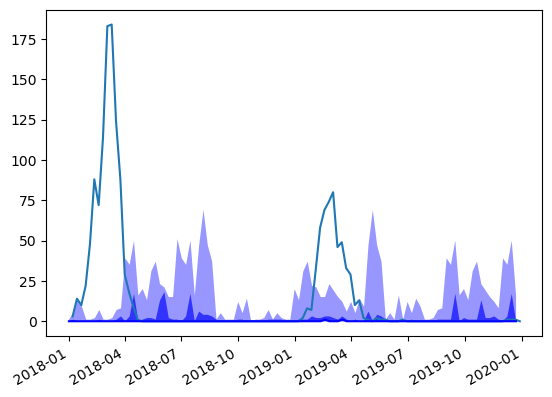

In [6]:
for location in ['LK Bad Dürkheim']:
    plt.plot((corrected_df.loc[(corrected_df['location'] == location) &
                        (corrected_df.index <= config.test_end_time) &
                        (corrected_df.index >= config.train_end_time)].index),
         corrected_df.loc[(corrected_df['location'] == location) &
                       (corrected_df.index <= config.test_end_time) &
                       (corrected_df.index >= config.train_end_time), 'value'])
    plt.grid(which="both")
for g in f:
    g.plot()

In [11]:
forecast_ts = estimator.predict_time_series(train_set_df[train_set_df.location == "LK Bad Dürkheim"],num_samples=1)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# DeepVARHierarchical

In [3]:
from gluonts.model.deepvar_hierarchical import DeepVARHierarchicalEstimator
estimator = DeepVARHierarchicalEstimator(freq=config.freq,
                          prediction_length=104,
                          target_dim=1,
                          trainer=config.trainer,
                          context_length=config.context_length,
                          
                          )
forecast = estimator.predict(one_ts_train_set)

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/deepvar_hierarchical/__init__.py:24: FutureWarning: The module gluonts.model.deepvar_hierarchical has been moved to gluonts.mx.model.deepvar_hierarchical. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepVARHierarchicalEstimator'.
  warnings.warn(


ValidationError: 1 validation error for DeepVARHierarchicalEstimatorModel
S
  field required (type=value_error.missing)

# DEEPVAR normally an extension of DeepAR

In [5]:
from gluonts.model.deepvar import DeepVAREstimator
estimator = DeepVAREstimator(freq=config.freq,
                          prediction_length=104,
                          target_dim=1,
                          trainer=config.trainer,
                          context_length=config.context_length,
                          )
predictor = estimator.create_predictor(transformation=)
forecast = estimator.predict(one_ts_train_set)

TypeError: DeepVAREstimator.create_predictor() missing 2 required positional arguments: 'transformation' and 'trained_network'

# DeepTPP

In [16]:
from gluonts.mx.model.tpp.deeptpp import DeepTPPEstimator
from gluonts.mx import Trainer
estimator = DeepTPPEstimator(freq=config.freq,
                          #prediction_length=104,
                          #target_dim=1,
                          trainer=Trainer(epochs=4, hybridize=False),
                          #context_length=config.context_length,
                          prediction_interval_length=1,
                          context_interval_length=1,
                          num_marks=3,
                          )
predictor = estimator.train(one_ts_train_set,freq=config.freq)
#forecast = predictor.predict(one_ts_train_set)

ValidationError: 1 validation error for ContinuousTimeInstanceSplitterModel
freq
  field required (type=value_error.missing)

# LSTNet

In [14]:
from gluonts.model.lstnet import LSTNetEstimator
estimator = LSTNetEstimator(#freq=config.freq,
                          prediction_length=104,
                          trainer=Trainer(epochs=4),
                          context_length=config.context_length,
                          num_series=1,
                          skip_size=1,
                          ar_window=1,
                          channels=1,
                          )

predictor = estimator.train(train_set)
#predictor = estimator.create_predictor(transformation=estimator.create_transformation(),
 #                                     trained_network=estimator.create_training_network())
#forecast = predictor.predict(one_ts_train_set)

  0%|          | 0/50 [00:00<?, ?it/s]


GluonTSDataError: Input for field "target" does not have the requireddimension (field: target, ndim observed: 1, expected ndim: 2)

# GPVAR

# WaveNet

# Transformer

# TemporalFusionTransformer

# Causal Convolutional Transformer

# Rotbaum

# N-BEATS

# MQ-RNN

# MQ-CNN

# GPForecaster

# Deep Renewal Processes

# Deep Factor

# Deep State

# R Forecast